# Naive RAG

**절차**

1. Naive RAG 수행

![langgraph-naive-rag](assets/langgraph-naive-rag.png)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import os

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-RAG


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

먼저, pdf_retriever 를 사용하여 검색 결과를 가져옵니다.

In [3]:
from func.docs import MongoEmbeddingRetrievalChain

# PDF 문서를 로드합니다.
mongodb = MongoEmbeddingRetrievalChain().create_chain()

# retriever와 chain을 생성합니다.
retriever = mongodb.retriever
chain = mongodb.chain

In [4]:
search_result = retriever.invoke("""

Attention mechanism이 뭐야

 """)
search_result

[Document(metadata={'source': '/Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx', 'doc_type': 'word'}, page_content='연관키워드: 검색 엔진, 데이터 검색, 정보 검색\n\n\n\nPage Rank\n\n\n\n정의: 페이지 랭크는 웹 페이지의 중요도를 평가하는 알고리즘으로, 주로 검색 엔진 결과의 순위를 결정하는 데 사용됩니다. 이는 웹 페이지 간의 링크 구조를 분석하여 평가합니다.\n\n예시: 구글 검색 엔진은 페이지 랭크 알고리즘을 사용하여 검색 결과의 순위를 정합니다.\n\n연관키워드: 검색 엔진 최적화, 웹 분석, 링크 분석\n\n\n\n데이터 마이닝'),
 Document(metadata={'source': '/Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx', 'doc_type': 'word'}, page_content='연관키워드: 검색 엔진 최적화, 웹 분석, 링크 분석\n\n\n\n데이터 마이닝\n\n\n\n정의: 데이터 마이닝은 대량의 데이터에서 유용한 정보를 발굴하는 과정입니다. 이는 통계, 머신러닝, 패턴 인식 등의 기술을 활용합니다.\n\n예시: 소매업체가 고객 구매 데이터를 분석하여 판매 전략을 수립하는 것은 데이터 마이닝의 예입니다.\n\n연관키워드: 빅데이터, 패턴 인식, 예측 분석\n\n\n\n멀티모달 (Multimodal)'),
 Document(metadata={'name': '정수아', 'age': '31', 'isMarried': 'False', 'carOwnership': 'True', 'phoneNumbers': ['337-5721-3227', '387-3768-9586'], 'hobbies': ['여행', '음악 감상', '

이전에 검색한 결과를 chain 의 context 로 전달합니다.

In [6]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = chain.invoke(
    {
        "question":
        """
        Attention mechanism이 뭐야
        """,
        # "question":
        # """
        # word2vec에 대해 알려줘
        # """,
        "context": search_result,
    }
)
print(answer)

Attention 메커니즘은 딥러닝과 자연어 처리에서 입력 데이터의 중요한 부분에 집중하여 가중치를 다르게 할당하는 기술입니다.

**Source**
- /Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx


## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

In [7]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [10]:
from langchain_teddynote.messages import messages_to_history
from func.utils import format_searched_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_searched_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

## 그래프 생성

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

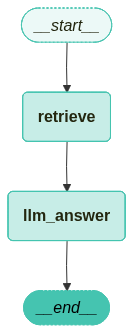

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

**참고**

- 메시지 출력 스트리밍은 [LangGraph 스트리밍 모드의 모든 것](https://wikidocs.net/265770) 을 참고해주세요.

아래의 `stream_graph` 함수는 특정 노드만 스트리밍 출력하는 함수입니다.

손쉽게 특정 노드의 스트리밍 출력을 확인할 수 있습니다.

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력

inputs = GraphState(question="attention 메커니즘의 원리와 역할에 대해 설명해 주세요")

# 그래프 실행
# stream_graph(app, inputs, config)
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>연관키워드: 데이터베이스, 데이터 모델링, 데이터 관리



DataFrame



정의: DataFrame은 행과 열로 이루어진 테이블 형태의 데이터 구조로, 주로 데이터 분석 및 처리에 사용됩니다.

예시: 판다스 라이브러리에서 DataFrame은 다양한 데이터 타입의 열을 가질 수 있으며, 데이터 조작과 분석을 용이하게 합니다.

연관키워드: 데이터 분석, 판다스, 데이터 처리



Attention 메커니즘</content><source>{'source': '/Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx', 'doc_type': 'word'}</source></document>
<document><content>연관키워드: 자연어 처리, 딥러닝, 라이브러리



Digital Transformation



정의: 디지털 변환은 기술을 활용하여 기업의 서비스, 문화, 운영을 혁신하는 과정입니다. 이는 비즈니스 모델을 개선하고 디지털 기술을 통해 경쟁력을 높이는 데 중점을 둡니다.

예시: 기업이 클라우드 컴퓨팅을 도입하여 데이터 저장과 처리를 혁신하는 것은 디지털 변환의 예입니다.

연관키워드: 혁신, 기술, 비즈니스 모델



Crawling</content><source>{'source': '/Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx', 'doc_type': 'word'}</source></document>
<document><content>name: 이지훈
age: 61
isMarried: True
carOwnership: 

In [14]:
# 그래프를 스트리밍 출력
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Word2Vec은 단어를 벡터 공간에 매핑하여 단어 간의 의미적 관계를 나타내는 자연어 처리 기술로, 단어의 문맥적 유사성을 기반으로 벡터를 생성합니다. 예를 들어, "왕"과 "여왕"은 Word2Vec 모델에서 서로 가까운 위치에 벡터로 표현됩니다.

**Source**
- /Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx

invoke graph -> 중간과정도 볼 수 있음
stram graph ->출력만해서 최종배포때는 이걸 활용하면됨

In [14]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: word2vec이 뭐야
Answer:
모르겠다.


In [15]:
outputs

{'question': 'word2vec이 뭐야',
 'context': '<document><content>연관키워드: 검색 엔진, 데이터 검색, 정보 검색\n\n\n\nPage Rank\n\n\n\n정의: 페이지 랭크는 웹 페이지의 중요도를 평가하는 알고리즘으로, 주로 검색 엔진 결과의 순위를 결정하는 데 사용됩니다. 이는 웹 페이지 간의 링크 구조를 분석하여 평가합니다.\n\n예시: 구글 검색 엔진은 페이지 랭크 알고리즘을 사용하여 검색 결과의 순위를 정합니다.\n\n연관키워드: 검색 엔진 최적화, 웹 분석, 링크 분석\n\n\n\n데이터 마이닝</content><source>{\'source\': \'/Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx\', \'doc_type\': \'word\'}</source></document>\n<document><content>연관키워드: 데이터 융합, 인공지능, 딥러닝</content><source>{\'source\': \'/Users/daehwankim/Documents/langgraph-tutorial-main/RAG_CHATBOT/files/sample-word-document.docx\', \'doc_type\': \'word\'}</source></document>\n<document><content>예시: 이미지 인식, 음성 인식, 자연어 처리 등에서 딥러닝 모델이 활용됩니다.\n\n연관키워드: 인공신경망, 머신러닝, 데이터 분석\n\n\n\nSchema\n\n\n\n정의: 스키마는 데이터베이스나 파일의 구조를 정의하는 것으로, 데이터가 어떻게 저장되고 조직되는지에 대한 청사진을 제공합니다.\n\n예시: 관계형 데이터베이스의 테이블 스키마는 열 이름, 데이터 타입, 키 제약 조건 등을 정의합니다.\n\n연관키워드: 데이터베이스, 데이터 모델링, 데이터 관리</content><so